# Convolutional Neural Networks (CNNs) & Hardware Acceleration

**Session Topic:** Feature Extraction, CNN Architecture, and PyTorch CPU vs. GPU Performance.

**Target Audience:** Professors and Instructors.

**Objectives:**
1.  **Intuition:** Understand how "Convolutions" extract features (like edges) from images.
2.  **Implementation:** Build a CNN using the **PyTorch** framework.
3.  **Acceleration:** Empirically demonstrate the speed difference between training/inference on a **CPU** vs. a **GPU**.

## 1. Environment Setup & PyTorch
PyTorch is a leading deep learning library. Unlike Scikit-Learn, it is designed to run on GPUs.

In [2]:
# Install PyTorch (Pre-installed in Google Colab, but good for reference)
# !pip install torch torchvision numpy matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time

print(f"PyTorch Version: {torch.__version__}")

# Check for GPU
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")

print(f"GPU Available? {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: No GPU detected. Go to Runtime > Change runtime type > Hardware accelerator > T4 GPU")

PyTorch Version: 2.9.1
GPU Available? False


## 2. Feature Extraction Intuition (The "Convolution")

Before training a massive network, let's understand what a CNN actually *does*.

A **Convolution** involves sliding a small matrix (Kernel/Filter) over an image to detect specific patterns (Vertical lines, Horizontal lines, Curves).

Below, we manually simulate a "Vertical Edge Detector" without any neural network training.

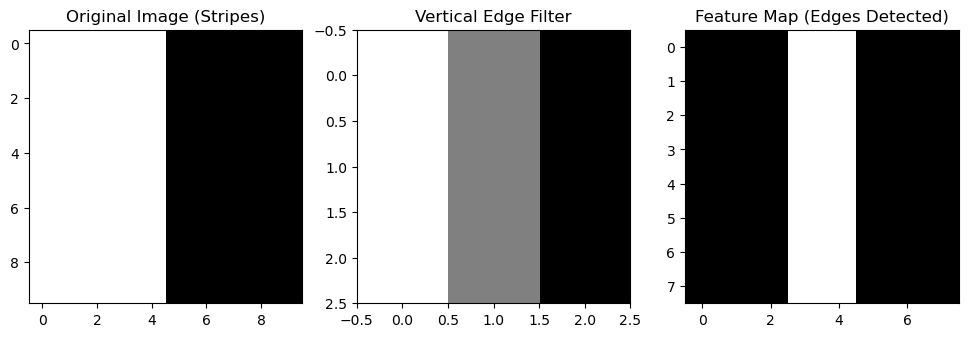

Notice how the output highlights exactly where the vertical transition happens.


In [3]:
def apply_convolution(image, kernel):
    """
    Simple manual 2D convolution operation.
    """
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    
    # Output dimension (assuming valid padding)
    out_h = img_h - k_h + 1
    out_w = img_w - k_w + 1
    
    output = np.zeros((out_h, out_w))
    
    # Slide the kernel
    for i in range(out_h):
        for j in range(out_w):
            # Extract region of interest (ROI)
            roi = image[i:i+k_h, j:j+k_w]
            # Element-wise multiplication and sum
            output[i, j] = np.sum(roi * kernel)
            
    return output

# 1. Create a synthetic image (Vertical stripes)
image = np.zeros((10, 10))
image[:, :5] = 10  # Left half is bright
image[:, 5:] = 0   # Right half is dark

# 2. Define a Vertical Edge Detection Filter
# This filter highlights changes from bright to dark
filter_vertical = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

# 3. Apply Convolution
feature_map = apply_convolution(image, filter_vertical)

# 4. Visualize
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(image, cmap='gray'); ax[0].set_title("Original Image (Stripes)")
ax[1].imshow(filter_vertical, cmap='gray'); ax[1].set_title("Vertical Edge Filter")
ax[2].imshow(feature_map, cmap='gray'); ax[2].set_title("Feature Map (Edges Detected)")
plt.show()

print("Notice how the output highlights exactly where the vertical transition happens.")

## 3. Dataset Preparation (CIFAR-10)

We will use **CIFAR-10**, a dataset of 60,000 32x32 color images in 10 classes (airplane, bird, cat, etc.).

In [ ]:
# Pre-processing: Convert to Tensor and Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize RGB channels
])

batch_size = 64

# Download Training Data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")

## 4. Defining the CNN Architecture

In PyTorch, we define networks as Classes inheriting from `nn.Module`.

**Architecture:**
1. **Conv1:** Extracts low-level features (edges, colors).
2. **Pool:** Reduces image size (downsampling).
3. **Conv2:** Extracts high-level features (shapes, patterns).
4. **FC (Fully Connected):** Makes the final classification.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Input: 3 channels (RGB), Output: 6 feature maps, Kernel: 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Input: 6 channels, Output: 16 feature maps, Kernel: 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Fully connected layers
        # 16 * 5 * 5 is the size after pooling twice
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 Output classes

    def forward(self, x):
        # Apply Conv1 -> ReLU -> Pool
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        # Apply Conv2 -> ReLU -> Pool
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        
        # Flatten the 3D tensor to 1D vector for FC layers
        x = torch.flatten(x, 1)
        
        # Dense layers
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print("Model Architecture Defined.")

## 5. Experiment: CPU vs. GPU Training Speed

We will define a generic training function that can accept a device (`cpu` or `cuda`) and train the model for 1 epoch. We will measure the wall-clock time for each.

In [ ]:
def train_model(device, epochs=1):
    # 1. Instantiate Model and move to Device (CPU or GPU)
    net = SimpleCNN().to(device)
    
    # 2. Define Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    print(f"--- Starting Training on {device} ---")
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        
        # Iterate over data batches
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            
            # CRITICAL STEP: Move inputs/labels to the specific device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    end_time = time.time()
    duration = end_time - start_time
    print(f"Finished Training on {device}.")
    print(f"Time Taken: {duration:.4f} seconds")
    return net, duration

### Run 1: CPU Training
This simulates running Deep Learning on a standard laptop without a dedicated graphics card.

In [ ]:
# Train on CPU
# Note: We are running only 1 Epoch because CPUs are slow!
model_cpu, time_cpu = train_model(device_cpu, epochs=1)

### Run 2: GPU Training
This utilizes the parallel processing power of the GPU (e.g., NVIDIA T4 in Colab). Notice the `.to(device)` logic in the function above handling the data transfer.

In [ ]:
if torch.cuda.is_available():
    # Train on GPU
    model_gpu, time_gpu = train_model(device_gpu, epochs=1)
    
    # Calculate Speedup
    speedup = time_cpu / time_gpu
    print(f"\nResult: GPU was {speedup:.2f}x faster than CPU for training.")
else:
    print("Skipping GPU test (No GPU available).")

## 6. Inference Speed Test

It's not just training; applying the model (inference) is also faster on GPU. This is critical for real-time applications (e.g., self-driving cars).

In [ ]:
def measure_inference(model, device, batches=50):
    model.eval() # Set to evaluation mode
    dataiter = iter(trainloader)
    
    start = time.time()
    with torch.no_grad(): # No need to calculate gradients for inference
        for i in range(batches):
            images, labels = next(dataiter)
            images = images.to(device)
            _ = model(images)
    end = time.time()
    return end - start

# Measure CPU Inference
inf_time_cpu = measure_inference(model_cpu, device_cpu)
print(f"Inference time (50 batches) on CPU: {inf_time_cpu:.4f}s")

if torch.cuda.is_available():
    # Measure GPU Inference
    inf_time_gpu = measure_inference(model_gpu, device_gpu)
    print(f"Inference time (50 batches) on GPU: {inf_time_gpu:.4f}s")
    
    print(f"Inference Speedup: {inf_time_cpu/inf_time_gpu:.2f}x")

## Conclusion

1.  **Convolutions:** We saw how simple filters can detect edges in images.
2.  **PyTorch:** We built a standard CNN Architecture (`Conv2d`, `MaxPool`, `Linear`).
3.  **Acceleration:** 
    -   **Training:** GPUs offer massive speedups (often 10x-50x) by parallelizing the forward/backward passes.
    -   **Inference:** Predicting on batches of data is also significantly faster on GPU.

**Note:** For very small models or tiny batch sizes, the overhead of moving data to the GPU might outweigh the benefits. However, for modern deep learning (ResNet, Transformers), GPUs are mandatory.